In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data preparation

In [4]:
import os
import re
from pathlib import Path
DATA_PATH = 'Dataset/trdg'

## Load the data

In [5]:
def create_dataset(img_paths):
    paths, labels, vocabs = [], [], []
    for path in img_paths:
        if os.path.getsize(path):
            label = re.sub('_.*', '', os.path.basename(path))
            paths.append(path)
            labels.append(label)
            vocabs.extend(list(label))
    return np.array(paths), np.array(labels), set(vocabs)

In [6]:
img_paths = list(map(str, Path(DATA_PATH).glob('*.jpg')))
img_paths, labels, vocabs = create_dataset(img_paths)

print('Number of training images:', len(img_paths))
print('Number of training labels:', len(labels))
print('Number of training vocabs:', len(vocabs))
print('Vocabularies in the training data:', vocabs)

Number of training images: 4434
Number of training labels: 4434
Number of training vocabs: 3291
Vocabularies in the training data: {'还', '𣴓', '𤈛', '製', '娥', '踸', '𦟐', '𣱽', '討', '\U000f000e', '城', '𨅸', '拖', '便', '制', '胤', '拜', '𡵆', '𭸓', '堛', '\U000f0821', '姉', '倣', '墮', '潔', '鵑', '𣎀', '我', '\U000f07cf', '森', '踖', '讀', '𤵺', '氷', '鳳', '蘂', '圭', '㩒', '𡞕', '踏', '𠴡', '唒', '刼', '淡', '𩛜', '鬟', '\U000f086b', '吲', '數', '泸', '注', '𬌥', '\U000f13a3', '簡', '魄', '\U000f03d9', '怪', '党', '解', '𤓢', '𬁑', '\U000f0152', '專', '𠳿', '舌', '根', '𫄄', '隱', '和', '\U000f0003', '梞', '叛', '𠰺', '𤞻', '\U000f15ba', '\U000f0df3', '蜀', '㤕', '貢', '泣', '\U000f05a7', '\U000f0284', '顕', '𤿰', '碎', '\U000f081c', '潤', '墨', '戎', '庙', '𭃂', '整', '粘', '\U000f080f', '各', '夏', '歐', '柂', '也', '濛', '凉', '偻', '妾', '𨕭', '臺', '鉄', '揇', '𤽸', '山', '道', '窒', '藝', '𪂲', '少', '𢙇', '紊', '量', '龍', '眜', '沖', '𡅧', '梗', '𡀢', '\U000f0cb9', '幔', '𬙞', '手', '絆', '徘', '畧', '滚', '鑿', '摱', '𠼾', '扦', '唪', '𪹚', '㩜', '𥅦', '𠲖', '\U000f000b', '郭', '默', '浙', '總',

## Dataset splitting

In [7]:
def split_data(img_paths, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(img_paths)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle: np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = img_paths[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = img_paths[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [8]:
x_train, x_valid, y_train, y_valid = split_data(img_paths, labels)
x_valid, x_test, y_valid, y_test = split_data(x_valid, y_valid, train_size=0.5)

print('Total training samples:', len(x_train))
print('Total validation samples:', len(x_valid))
print('Total testing samples:', len(x_test))

Total training samples: 3990
Total validation samples: 222
Total testing samples: 222


## Building the character vocabulary

In [9]:
# Mapping characters to integers
char_to_num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

## Preprocessing

In [10]:
MAX_LENGTH = max([len(label) for label in labels])
AUTOTUNE = tf.data.AUTOTUNE
PADDING_TOKEN = 99
BATCH_SIZE = 16
HEIGHT = 148
WIDTH = 32

In [11]:
def distortion_free_resize(image, img_size):
    h, w = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top, pad_height_bottom = height + 1, height
    else: pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left, pad_width_right = width + 1, width
    else: pad_width_left = pad_width_right = pad_width // 2

    return tf.pad(image, paddings=[
        [pad_height_top, pad_height_bottom],
        [pad_width_left, pad_width_right],
        [0, 0],
    ])

In [12]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

## Prepare `tf.data.Dataset` objects

In [13]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [59]:
train_tf_dataset = prepare_tf_dataset(x_train, y_train)
valid_tf_dataset = prepare_tf_dataset(x_valid, y_valid)
test_tf_dataset = prepare_tf_dataset(x_test, y_test)
train_tf_dataset

<PrefetchDataset shapes: {image: (None, None, None, 1), label: (None, None), label_length: (None,)}, types: {image: tf.float32, label: tf.int64, label_length: tf.int32}>

## Visualize the data

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import transforms

NROWS, NCOLS = (2, 8)
assert NROWS * NCOLS <= BATCH_SIZE, f'NROWS * NCOLS must be <= {BATCH_SIZE}'
font = fm.FontProperties(fname='NomNaTong-Regular.ttf')

Image shape: (148, 32, 1)


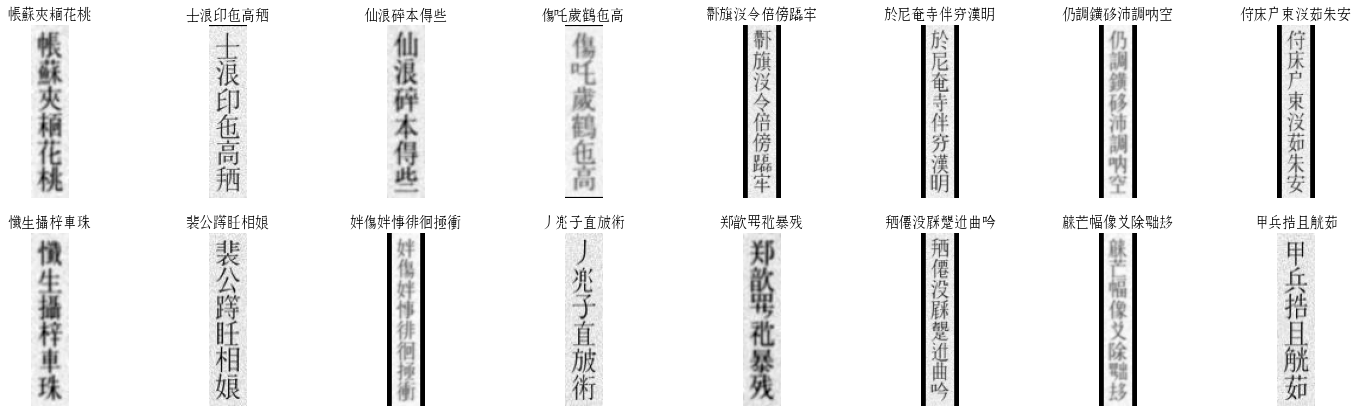

In [20]:
plt.figure(figsize=(25, 7))
for batch in train_tf_dataset.take(1):
    batch_images, batch_labels = batch['image'], batch['label']
    print('Image shape:', batch_images[0].shape)

    for i in range(min(NROWS * NCOLS, BATCH_SIZE)):
        plt.subplot(NROWS, NCOLS, i + 1)
        img = (batch_images[i] * 255.0).numpy().astype(np.uint8)
        
        # Gather indices where label != padding_token.
        indices = tf.gather(
            batch_labels[i], 
            tf.where(tf.math.not_equal(batch_labels[i], PADDING_TOKEN))
        )
        label = tf.strings.reduce_join(num_to_char(indices)) # Convert to string
        label = label.numpy().decode('utf-8')

        plt.imshow(img[:, :, 0], cmap='gray')
        plt.title(label, fontproperties=font, fontsize=14)
        plt.axis('off')

# Define the model

In [22]:
from tensorflow.keras.layers import (
    Input, BatchNormalization, LeakyReLU, Reshape,
    Conv2D, MaxPool2D, Dense, Bidirectional, GRU
)
from tensorflow.keras.models import Model

## CTC Loss

In [21]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name='ctc_loss')
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, label_length):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        input_length *= tf.ones(shape=(batch_length, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred # At test time, just return the computed predictions.

## CRNN

In [34]:
def build_model(config, optimizer, name):
    image_input = Input(shape=(HEIGHT, WIDTH, 1), name='image')
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    print(config)
    
    # Convolution layer with BatchNormalization & LeakyReLU activation
    def conv2D_bn(input_layer, filters, block_name, conv_idx):
        x = Conv2D(
            filters = filters, 
            kernel_size = (3, 3), 
            padding = 'same', 
            kernel_initializer = 'he_normal',
            name = f'{block_name}_conv{conv_idx}'
        )(input_layer)
        x = BatchNormalization(name=f'{block_name}_bn{conv_idx}')(x)
        return LeakyReLU(alpha=0.2, name=f'{block_name}_activation{conv_idx}')(x)

    # Generate Convolutional blocks
    for idx, (block_name, block_config) in enumerate(config['conv_blocks'].items()):
        num_conv, filters = block_config
        for conv_idx in range(num_conv):
            input_layer = image_input if idx == 0 and conv_idx == 0 else x
            x = conv2D_bn(input_layer, filters, block_name, conv_idx + 1)
        x = MaxPool2D(pool_size=(2, 2), name=f'{block_name}_pool')(x)

    # Reshape accordingly before passing the output to the RNN part
    _, height, width, channel = x.get_shape()
    x = Reshape(target_shape=(height, width * channel), name='reshape')(x)

    # RNN layers
    for idx in range(config['rnn_deep_num']):
        x = Bidirectional(GRU(
            units = 256, 
            return_sequences = True, 
            kernel_initializer = 'he_normal',
            dropout = 0.25
        ), name = f'bigru{idx}')(x)

    # Output layer
    vocab_units = len(char_to_num.get_vocabulary()) + 2
    y_pred = Dense(vocab_units, activation='softmax', name='RNN_output')(x)
    
    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    model.compile(optimizer=optimizer)
    pred_model = Model(inputs=image_input, outputs=y_pred)
    return model, pred_model

## Evaluation metric

In [43]:
validate_images = []
validate_labels = []
for batch in valid_tf_dataset:
    validate_images.append(batch['image'])
    validate_labels.append(batch['label'])

In [44]:
def calculate_edit_distance(labels, preds):
    # Get a single batch and convert its labels to sparse tensors.
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype='int64')

    # Make predictions and convert them to sparse tensors.
    preds_decoded = tf.keras.backend.ctc_decode(
        preds, 
        input_length = np.ones(preds.shape[0]) * preds.shape[1], 
        greedy = True
    )[0][0][:, :MAX_LENGTH]
    sparse_preds = tf.cast(tf.sparse.from_dense(preds_decoded), dtype='int64')

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(sparse_preds, sparse_labels, normalize=False)
    return tf.reduce_mean(edit_distances)

# Training

## Build the model

Generate Convolutional blocks & Bidirectional RNN layers by the following format:
```json
config = {
    'conv_blocks': {
        Name of the convolutional block: [
            Number of "conv2D_bn" layers,
            Number of filters for each "conv2D_bn" layer
        ]
    },
    'rnn_deep_num': Number of Bidirectional RNN layers
}
```

In [45]:
from tensorflow.keras.optimizers import Adam
config = {
    'conv_blocks': {
        'bl1': [2, 64],  # block 1 with 2 "conv2D_bn" layers,  64 filters for each
        'bl2': [2, 128], # block 2 with 2 "conv2D_bn" layers, 128 filters for each
        'bl3': [4, 256]  # block 3 with 4 "conv2D_bn" layers, 256 filters for each
    },
    'rnn_deep_num': 2 # Number of Bidirectional RNN layers
}
optimizer = Adam(learning_rate=1e-4)
model, pred_model = build_model(config, optimizer, name='CRNN_OCR')
model.summary()                                

{'conv_blocks': {'bl1': [2, 64], 'bl2': [2, 128], 'bl3': [4, 256]}, 'rnn_deep_num': 2}
Model: "CRNN_OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 bl1_conv1 (Conv2D)             (None, 148, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 bl1_bn1 (BatchNormalization)   (None, 148, 32, 64)  256         ['bl1_conv1[0][0]']              
                                                                                                  
 bl1

## Callbacks

In [46]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

# Keeps initial learning rate for first 3 epochs, decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 2: return lr
    return lr * tf.math.exp(-0.1)
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates => new_lr = lr * factor. 
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5, 
    restore_best_weights = True, 
    verbose = 1
)

In [48]:
class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        for i in range(len(validate_images)):
            preds = self.prediction_model.predict(validate_images[i])
            edist = calculate_edit_distance(validate_labels[i], preds)
            edit_distances.append(edist.numpy())
        print(f' - Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}')

## `Model.fit` the CRNN 

In [49]:
%%timeit
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = 100,
    callbacks = [
        # schedule_lr_callback, 
        reduce_lr_callback, 
        early_stopping_callback,
        EditDistanceCallback(pred_model), 
    ],
    verbose = 1
)
model.save('crnn.h5')

Epoch 1/100
250/250 [==============================] - 14s 39ms/step - loss: 55.2701 - val_loss: 51.7934 - lr: 1.0000e-04
Epoch 2/100
250/250 [==============================] - 8s 31ms/step - loss: 51.0172 - val_loss: 51.7916 - lr: 1.0000e-04
Epoch 3/100
250/250 [==============================] - 8s 31ms/step - loss: 50.6029 - val_loss: 51.4585 - lr: 1.0000e-04
Epoch 4/100
250/250 [==============================] - 8s 31ms/step - loss: 49.9274 - val_loss: 50.8244 - lr: 1.0000e-04
Epoch 5/100
250/250 [==============================] - 8s 32ms/step - loss: 48.8812 - val_loss: 49.5909 - lr: 1.0000e-04
Epoch 6/100
250/250 [==============================] - 8s 31ms/step - loss: 47.1932 - val_loss: 48.0813 - lr: 1.0000e-04
Epoch 7/100
250/250 [==============================] - 8s 31ms/step - loss: 43.3228 - val_loss: 40.4975 - lr: 1.0000e-04
Epoch 8/100
250/250 [==============================] - 8s 31ms/step - loss: 35.6214 - val_loss: 34.0477 - lr: 1.0000e-04
Epoch 9/100
250/250 [==========

Epoch 37/100
250/250 [==============================] - 8s 31ms/step - loss: 0.9859 - val_loss: 6.2703 - lr: 5.0000e-05
Epoch 38/100
250/250 [==============================] - 8s 31ms/step - loss: 0.9019 - val_loss: 6.2076 - lr: 5.0000e-05
Epoch 39/100
250/250 [==============================] - 8s 31ms/step - loss: 0.8290 - val_loss: 6.1586 - lr: 5.0000e-05
Epoch 40/100
250/250 [==============================] - 8s 31ms/step - loss: 0.7588 - val_loss: 6.0579 - lr: 5.0000e-05
Epoch 41/100
250/250 [==============================] - 8s 31ms/step - loss: 0.7000 - val_loss: 6.1198 - lr: 5.0000e-05
Epoch 42/100
249/250 [============================>.] - ETA: 0s - loss: 0.6349
Epoch 00042: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance for epoch 42: 1.8878
250/250 [==============================] - 8s 31ms/step - loss: 0.6346 - val_loss: 6.2793 - lr: 5.0000e-05
Epoch 43/100
250/250 [==============================] - 8s 31ms/step - loss: 0.5811 - val_l

## Visualize training result

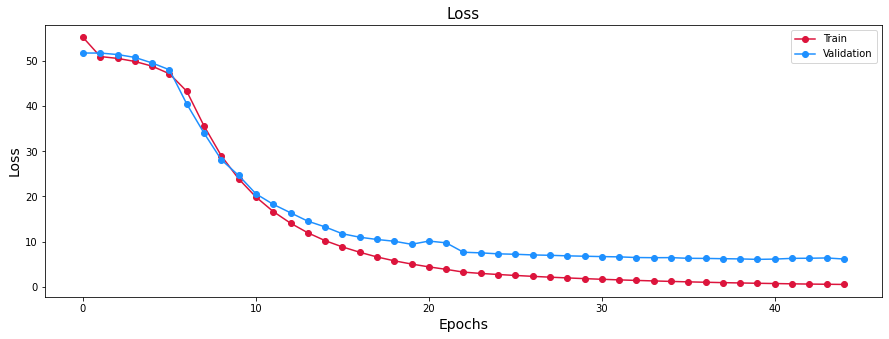

In [58]:
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig('crnn_history.png', bbox_inches='tight') 
plt.show()

# Inference

In [52]:
# A utility function to decode the output of the network
def decode_batch_predictions(preds):
    # Use greedy search. For complex tasks, you can use beam search
    preds_decoded = tf.keras.backend.ctc_decode(
        preds, 
        input_length = np.ones(preds.shape[0]) * preds.shape[1], 
        greedy = True
    )[0][0][:, :MAX_LENGTH]

    # Iterate over the results and get back the text
    output_text = []
    for result in preds_decoded:
        result = tf.gather(result, tf.where(tf.math.not_equal(result, -1)))
        result = tf.strings.reduce_join(num_to_char(result))
        output_text.append(result.numpy().decode('utf-8'))
    return output_text

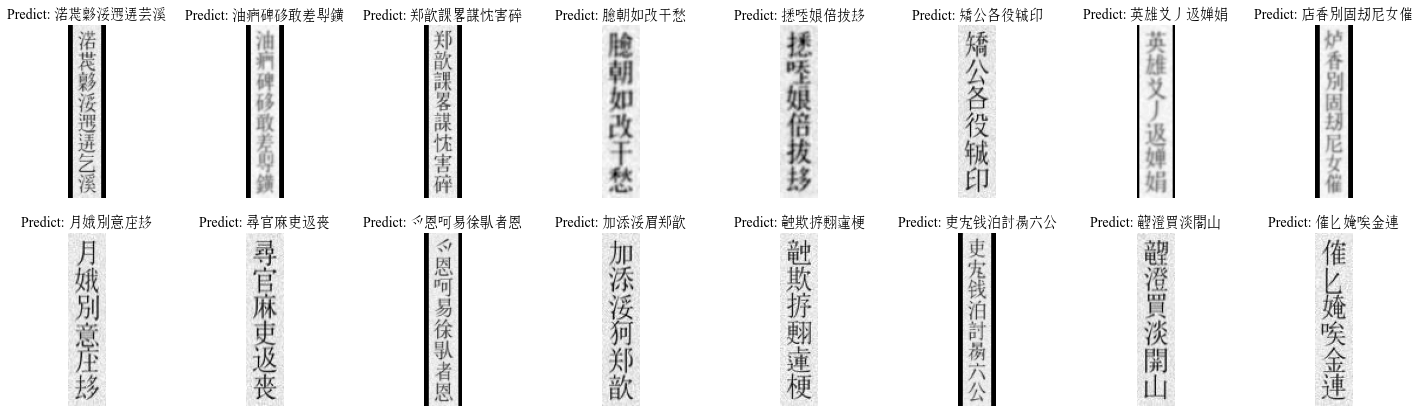

In [57]:
plt.figure(figsize=(25, 7))
for batch in test_ds.take(1):
    batch_images, batch_labels = batch['image'], batch['label']
    preds = pred_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    original_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label))
        original_texts.append(label.numpy().decode('utf-8'))

    for i in range(min(NROWS * NCOLS, BATCH_SIZE)):
        plt.subplot(NROWS, NCOLS, i + 1)
        img = (batch_images[i] * 255.0).numpy().astype(np.uint8)

        plt.imshow(img[:, :, 0], cmap='gray')
        plt.title(
            f'Predict: {pred_texts[i]}', 
            fontproperties = font, 
            fontsize = 14
        )
        plt.axis('off')